In [122]:
using Sunny
using GLMakie
Makie.inline!(true)

# include plotting function for chirality heatmaps
include(joinpath(pkgdir(Sunny), "examples", "extra", "plotting2d.jl"))
z_mean(s1, s2, s3) = (s1[3] + s2[3] + s3[3]) / 3

z_mean (generic function with 1 method)

### The 'Okubo' model (https://arxiv.org/abs/1109.6161v2)

Once again, let's look at a $J_1$-$J_3$ Heisenberg model on a triangular lattice with Hamiltonian: 

\begin{equation}
\mathcal{H} = J_1 \sum\limits_{\left<i,j\right>} \vec{S}_i\cdot\vec{S}_j + J_3\sum\limits_{\left<\left<i,j\right>\right>}\vec{S}_i\cdot\vec{S}_j - H\sum\limits_i\vec{S}_i 
\end{equation}

This should exhibit interesting skyrmion and spiral orderings.

We're going to use a smaller system size for this example for the sake of runtime.

In [123]:
# setup 2D triangular lattice
a, c = 1.0, 10.0
latvecs = lattice_vectors(a, a, c, 90, 90, 120)
positions = [[0, 0, 0]]
cryst = Crystal(latvecs, positions)

# setup 2D system 
L = 36
sys = System(cryst, (L, L, 1), [SpinInfo(1; S=1, g=1,)], :dipole, units=Units.theory, seed=0)
N = length(sys.dipoles)

# ferromagnetic nearest neighbor exchange interaction
J₁ = -1
set_exchange!(sys, J₁, Bond(1, 1, [1,0,0]))
# antiferromagnetic third-nearest neighbor exchange interaction
J₃ = 3.0 * abs(J₁)
set_exchange!(sys, J₃, Bond(1, 1, [2,0,0]))

# external magnetic field
h = 2.0 * J₃
set_external_field!(sys, [0, 0, h])

# start with random spin state
randomize_spins!(sys)

This time, we're going to use a `Langevin` type to simulate each temperature with parallel tempering instead of Metropolis MC.

In [124]:
# use a Langevin sampler
Δt = 0.02
λ = 0.1
sampler = Langevin(Δt; kT=0, λ);

The setup of `ParallelTempering` proceeds just like before. Now we have a more replicas relative to the system size.

In [125]:
n_replicas = 100

# temperature schedule for parallel tempering
kT_min, kT_max = (1e-2 * J₃), (0.75 * J₃)
kT_sched = collect(range(kT_min, kT_max, length=n_replicas))

kT = 0.35 * J₃
id_measure = argmin(abs.(kT_sched .- kT))
println("data measured at kT/J₃ = ", kT_sched[id_measure]/J₃, " vs. interested at kT/J₃ = ", kT/J₃)

# initialize parallel tempering 
PT = Sunny.ParallelTempering(sys, sampler, kT_sched);

data measured at kT/J₃ = 0.3463636363636364 vs. interested at kT/J₃ = 0.3499999999999999


In [126]:
function get_statistics(PT::Sunny.ParallelTempering)
    return PT.n_accept[1:end-1] ./ PT.n_exch[1:end-1]
end

function reset_statistics!(PT::Sunny.ParallelTempering)
    PT.n_accept .= 0
    PT.n_exch .= 0
    return nothing 
end

reset_statistics! (generic function with 1 method)

Just like before, we need to equilibrate the systems. 

Note one difference is that unlike the `LocalSampler`, a `Langevin` type has no fields called $\Delta E$ and $\Delta s$. This means that you need to refer to the systems at each temperature using `PT.system_ids`. 

This should take about 30 seconds.

In [127]:
# sampling parameters
n_init = 5_000
exch_interval = 15
measure_interval = 2*exch_interval
n_measure = cld(n_init, measure_interval)

# energy timeseries
Evt_init = zeros(n_measure, n_replicas)

# perform equilibration using parallel tempering MC
for i in 1:n_measure
    Sunny.step_ensemble!(PT, measure_interval, exch_interval)
    Evt_init[i, :] .= energy.(PT.systems[PT.system_ids]) ./ N
end

# reset acceptance rate statistics before production simulation
reset_statistics!(PT)

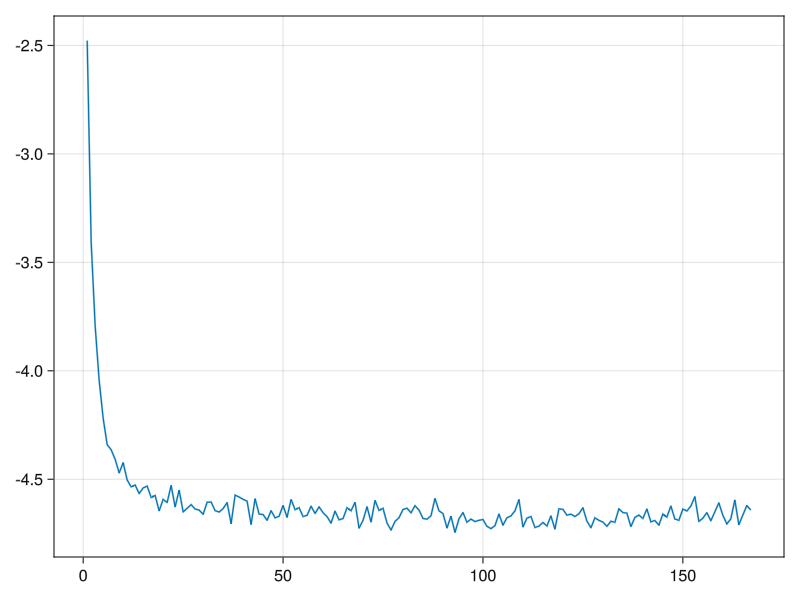

E = -4.641997799456882


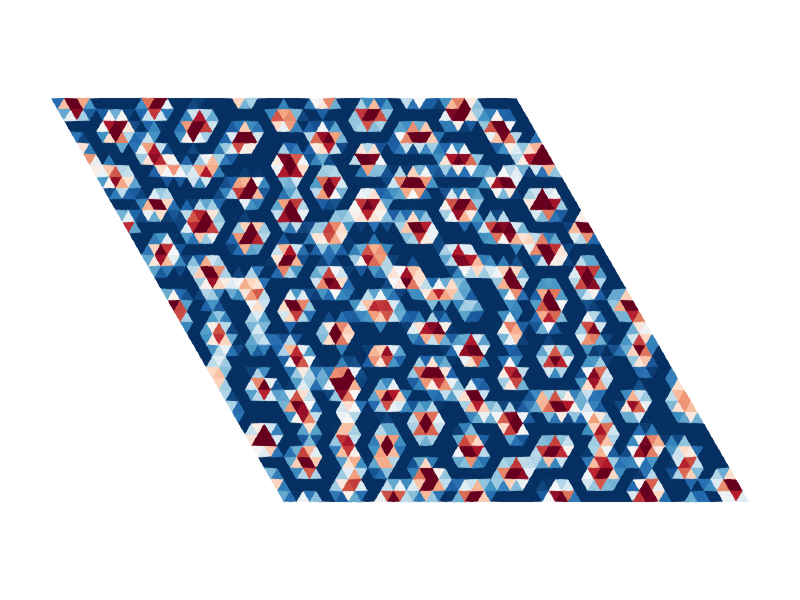

In [128]:
fig = Figure()
lines(fig[1,1], 1:n_measure, Evt_init[:,id_measure])
display(fig)

println("E = ", energy(PT.systems[PT.system_ids[id_measure]]) / N)
plot_triangular_plaquettes(z_mean, [PT.systems[PT.system_ids[id_measure]].dipoles])

When we do our measurements, the `PT.system_ids` are use to track the trajectories of individual replicas across the space of temperatures. This can give a quick visual interpretation of our simulation.

This should take about 1 minute.

In [129]:
# sampling parameters
n_measure = 1_000
exch_interval = 2
measure_interval = 2*exch_interval
n_steps = n_measure * measure_interval

# energy histograms for each replica -- choose a binning size
E_hists = [ Sunny.Histogram(bin_size=5e-3) for _ in 1:n_replicas ]
# trajectories of each replica in temperature space
trajectory_ids = zeros(n_measure, n_replicas)

# start parallel tempering simulation for measurements 
for n in 1:n_measure
    (n % 100 == 0) && println(n, " measurements")
    Sunny.step_ensemble!(PT, measure_interval, exch_interval)

    @Threads.threads for i in 1:n_replicas
        trajectory_ids[n, PT.system_ids[i]] = i

        E = energy(PT.systems[PT.system_ids[i]]) / N
        E_hists[i][E] += 1
    end
end

100 measurements


200 measurements


300 measurements


400 measurements


500 measurements


600 measurements


700 measurements


800 measurements


900 measurements


1000 measurements


The replica-exchange acceptance rates are once again very low at lower temperatures. This is not ideal, as this is equivalent to doing Metropolis MC at the temperatures. 

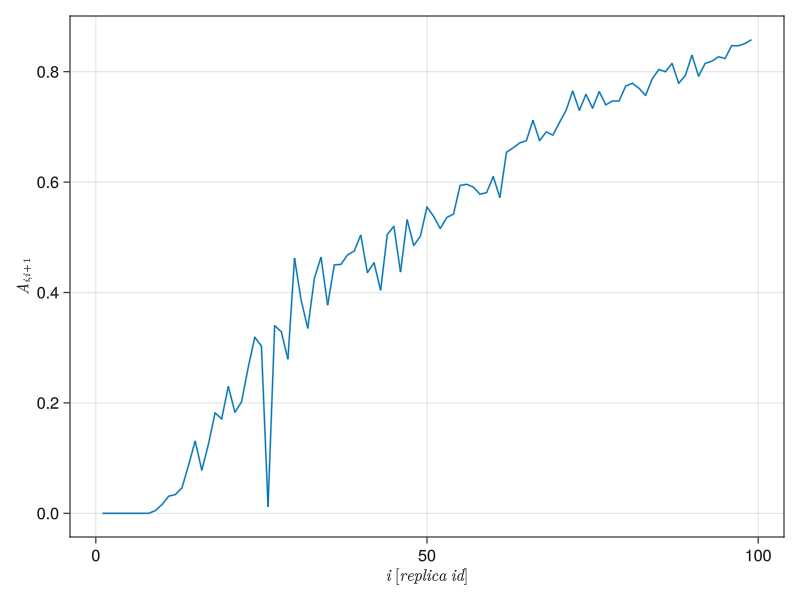

replica-exchange acceptance = 0.437 at kT/J₃ = 0.35
minimum replica-exchange acceptance: 0.0


In [130]:
# replica-exchange acceptance
A_exch = get_statistics(PT)

fig = Figure()
lines(fig[1,1], 1:n_replicas-1, A_exch, axis=(xlabel=L"i\;[replica\;id]", ylabel=L"A_{i, i+1}"))
display(fig)

println("replica-exchange acceptance = ", A_exch[id_measure], " at kT/J₃ = 0.35")
println("minimum replica-exchange acceptance: ", minimum(A_exch))

reset_statistics!(PT)

The replicas are not communicating at all at the lower temperatures, as evident by the replica trajectories. 

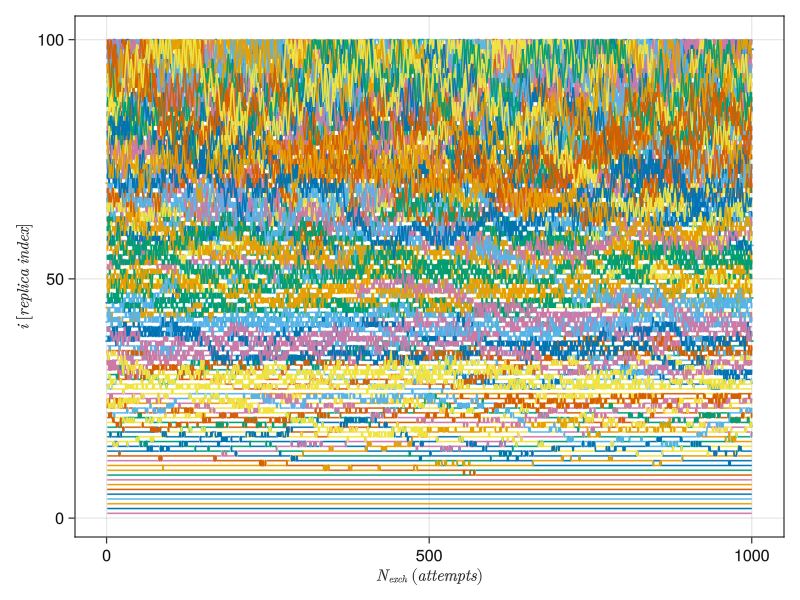

GLMakie.Screen(...)

In [131]:
fig = Figure()
Axis(fig[1,1], xlabel=L"N_{exch}\;(attempts)", ylabel=L"i\;[replica\;index]")
for i in 1:n_replicas
    lines!(1:n_measure, trajectory_ids[:,i])
end
display(fig)

We need to try and choose a temperature schedule so that these energy distributions overlap to a greater extent and we recover some successful replica exchanges.

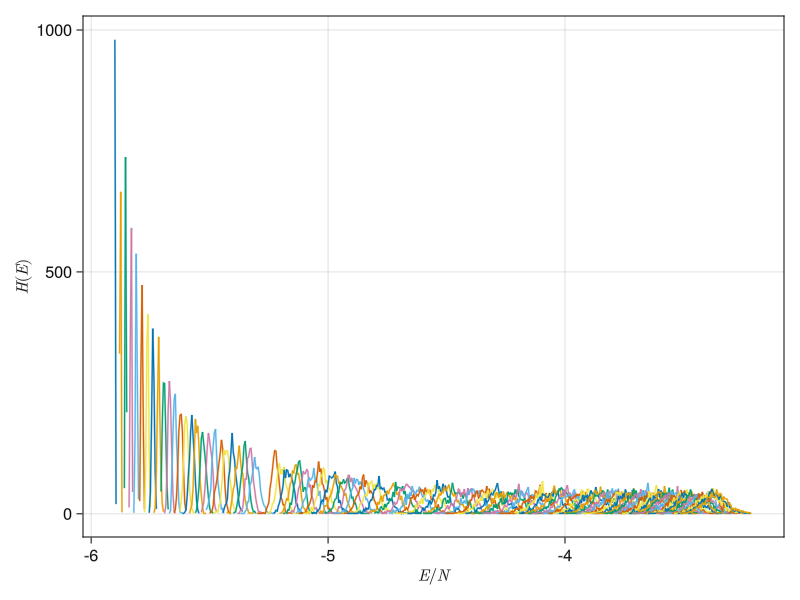

GLMakie.Screen(...)

In [132]:
fig = Figure()
Axis(fig[1,1], xlabel=L"E / N", ylabel=L"H(E)")
for H in E_hists
    lines!(Sunny.get_keys(H), Sunny.get_vals(H))
end
display(fig)

Let's choose a geometric temperature schedule. This is a reasonable starting point when working with models that have continuous spins. Keep in mind, our choice of temperature schedule will be influenced by the physics of our system - if there is a phase transition, we will want to have more temperatures in that vicinity.

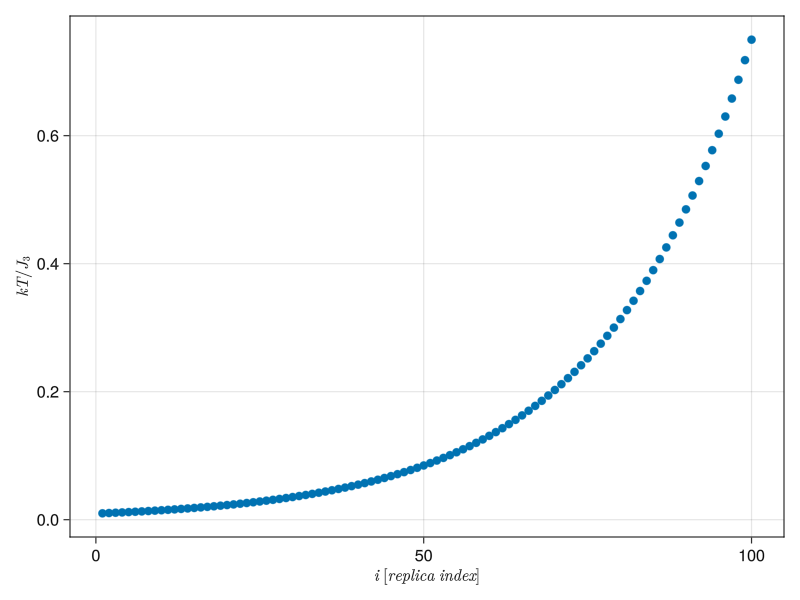

GLMakie.Screen(...)

In [133]:
# set a different kT schedule -- geometric series
PT.kT_sched = kT_sched = 10 .^ collect(range(log10(kT_min), log10(kT_max), length=n_replicas))
setproperty!.(PT.samplers, :kT, PT.kT_sched);

fig = Figure()
scatter(fig[1,1], 1:n_replicas, PT.kT_sched ./ J₃, axis=(xlabel=L"i\;[replica\;index]", ylabel=L"kT/J_3"))
display(fig)

Equilibrating again for the new temperatures. This should take about 30 seconds.

In [134]:
# sampling parameters
n_init = 5_000
exch_interval = 10
measure_interval = 2*exch_interval
n_measure = cld(n_init, measure_interval)

# energy timeseries
Evt_init = zeros(n_measure, n_replicas)

# perform equilibration using parallel tempering MC
for i in 1:n_measure
    Sunny.step_ensemble!(PT, measure_interval, exch_interval)
    Evt_init[i, :] .= energy.(PT.systems[PT.system_ids]) ./ N
end

# reset acceptance rate statistics before production simulation
reset_statistics!(PT)

Now let's make the same measurements at the new temperature schedule and see the replica trajectories. This should take about 1 minute.

In [135]:
# sampling parameters
n_measure = 1_000
exch_interval = 2
measure_interval = 2*exch_interval
n_steps = n_measure * measure_interval

# energy histograms for each replica -- choose a binning size
E_hists = [ Sunny.Histogram(bin_size=5e-3) for _ in 1:n_replicas ]
# trajectories of each replica in temperature space
trajectory_ids = zeros(n_measure, n_replicas)

# start parallel tempering simulation for measurements 
for n in 1:n_measure
    (n % 100 == 0) && println(n, " measurements")
    Sunny.step_ensemble!(PT, measure_interval, exch_interval)

    @Threads.threads for i in 1:n_replicas
        trajectory_ids[n, PT.system_ids[i]] = i

        E = energy(PT.systems[PT.system_ids[i]]) / N
        E_hists[i][E] += 1
    end
end

100 measurements


200 measurements


300 measurements


400 measurements


500 measurements


600 measurements


700 measurements


800 measurements


900 measurements


1000 measurements


This time, the replica-exchange acceptance looks a lot better. There's still a bottleneck at a phase transition as seen by the one temperature where few replica exchanges are accepted.

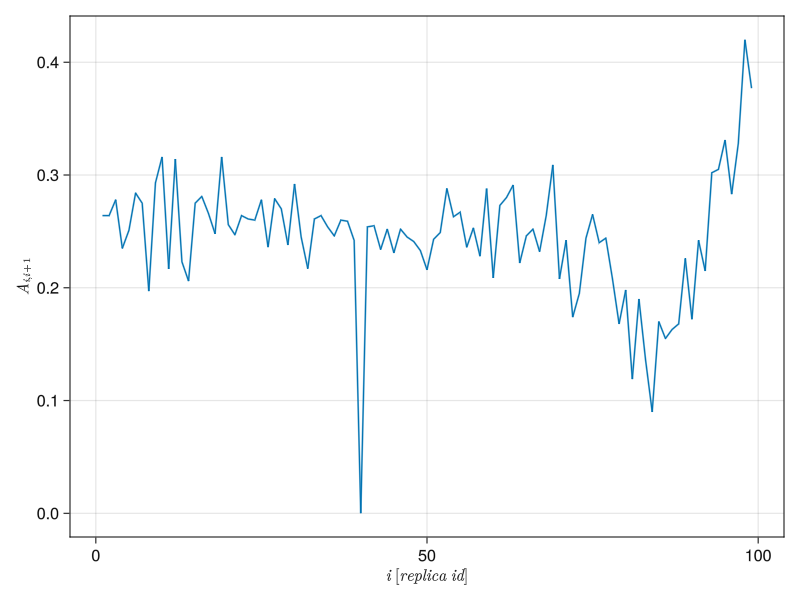

replica-exchange acceptance = 0.252 at kT/J₃ = 0.35
minimum replica-exchange acceptance: 0.0


In [136]:
# replica-exchange acceptance
A_exch = get_statistics(PT)

fig = Figure()
lines(fig[1,1], 1:n_replicas-1, A_exch, axis=(xlabel=L"i\;[replica\;id]", ylabel=L"A_{i, i+1}"))
display(fig)

println("replica-exchange acceptance = ", A_exch[id_measure], " at kT/J₃ = 0.35")
println("minimum replica-exchange acceptance: ", minimum(A_exch))

reset_statistics!(PT)

We see that replicas move up and down in temperature! 

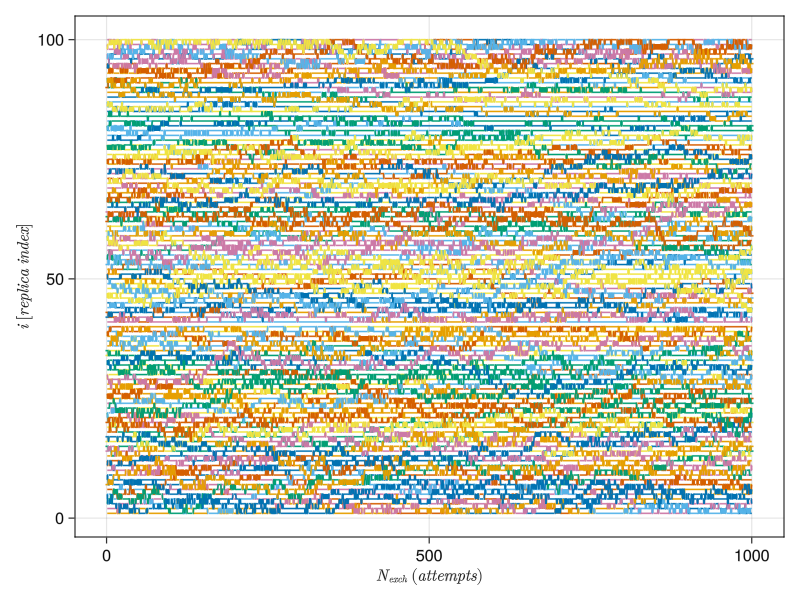

GLMakie.Screen(...)

In [137]:
fig = Figure()
Axis(fig[1,1], xlabel=L"N_{exch}\;(attempts)", ylabel=L"i\;[replica\;index]")
for i in 1:n_replicas
    lines!(1:n_measure, trajectory_ids[:,i])
end
display(fig)

Finally, here's what the energy distributions look like.

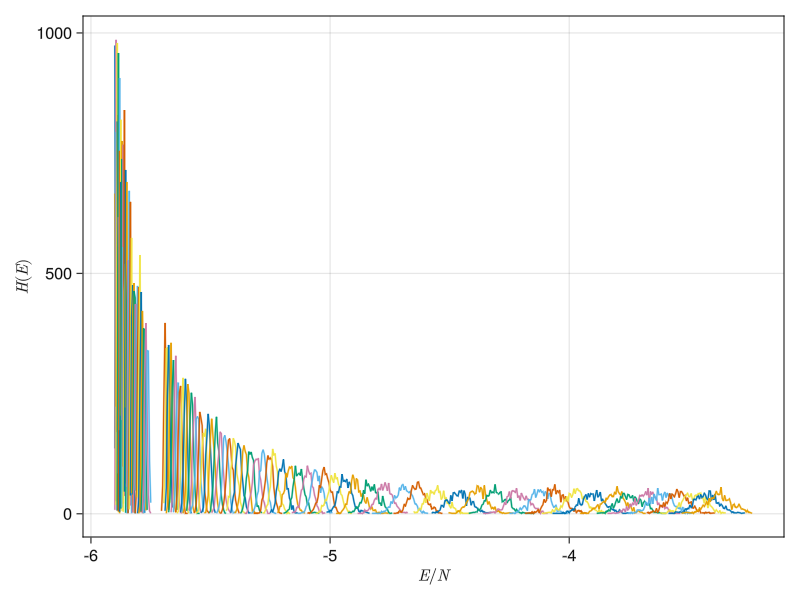

GLMakie.Screen(...)

In [138]:
fig = Figure()
Axis(fig[1,1], xlabel=L"E / N", ylabel=L"H(E)")
for H in E_hists
    lines!(Sunny.get_keys(H), Sunny.get_vals(H))
end
display(fig)

There are several automated schemes for selecting temperature schedules. This is one of the planned additions for parallel tempering in Sunny.